In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
#import xgboost as xgb
#import catboost as cb
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_csv('./train_s1/exam_score.csv')
df_test = pd.read_csv('./test_s1/submission_s1.csv')
df_test.rename(columns={'pred':'score'},inplace = True)
course_class = pd.read_csv('./train_s1/course.csv')
student = pd.read_csv('./train_s1/student.csv')
all_know = pd.read_csv('./train_s1/all_knowledge.csv')
df_all = df_train.append(df_test)
df_all = df_all.merge(course_class, on='course', how='left')
df_all = df_all.merge(student, on='student_id', how='left')

In [3]:
tmp1 = df_train.groupby(by=['student_id','course'], as_index=False)['score'].agg({'mean_score':np.mean, 'median_score':np.median, 'std_score':np.std,'max_score':np.max,'min_score':np.min})
tmp2 = df_train.groupby(by=['student_id'], as_index=False)['score'].agg({'s_mean_score':np.mean, 's_median_score':np.median, 's_std_score':np.std,'s_max_score':np.max,'min_score':np.min})

In [4]:
df_all=df_all.merge(tmp1, on=['student_id','course'], how='left')
df_all=df_all.merge(tmp2, on=['student_id'], how='left')

In [5]:
course1_exam = pd.read_csv('./train_s1/course1_exams.csv')
course2_exam = pd.read_csv('./train_s1/course2_exams.csv')
course3_exam = pd.read_csv('./train_s1/course3_exams.csv')
course4_exam = pd.read_csv('./train_s1/course4_exams.csv')
course5_exam = pd.read_csv('./train_s1/course5_exams.csv')
course6_exam = pd.read_csv('./train_s1/course6_exams.csv')
course7_exam = pd.read_csv('./train_s1/course7_exams.csv')
course8_exam = pd.read_csv('./train_s1/course8_exams.csv')
#col_c1 = [i for i in course1_exam.columns if i not in ['course','exam_id']]
tmp4=1
for i in [course1_exam,course2_exam,course3_exam,course4_exam,course5_exam,course6_exam,course7_exam,course8_exam]:
    name = i
    col_c1 = [i for i in name.columns if i not in ['course','exam_id']]
    name['course'] ='course'+str(tmp4)
    tmp2 =np.array(all_know.loc[all_know['course'] == ('course'+str(tmp4)),:]['complexity'])
    tmp = name[col_c1]
    tmp3 =np.dot(tmp.values,tmp2)
    name['hard'] = tmp3
    name['hard_inverse'] = name['hard'].apply(lambda x:1/(x+1e-10))
    tmp4 = tmp4+1

course_exam = course1_exam.append(course2_exam)
course_exam = course_exam.append(course3_exam)
course_exam = course_exam.append(course4_exam)
course_exam = course_exam.append(course5_exam)
course_exam = course_exam.append(course6_exam)
course_exam = course_exam.append(caourse7_exam)
course_exam = course_exam.append(course8_exam)
course_exam.fillna(0,inplace = True)

c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
sub_course_exam = course_exam[['course','exam_id','hard','hard_inverse']]

In [7]:
df_all.shape

(73500, 16)

In [8]:
df_all=df_all.merge(sub_course_exam, on=['exam_id','course'], how='left')

In [9]:
df_all.shape

(73500, 18)

In [10]:
for i in ['course','course_class','exam_id','student_id']:
    lbl = LabelEncoder()
    #all_data[i+"_count"] = all_data.groupby([i])[i].transform('count')
    #all_data[i+"_rank"] = all_data[i+"_count"].rank(method='min')
    df_all[i] = lbl.fit_transform(df_all[i].astype(str))

In [11]:
df_train = df_all[:65500]
df_test = df_all[65500:].reset_index(drop=True)
col = [i for i in df_all.columns if i not in ['score']]
X_train = df_train[col]
y = df_train['score']

In [16]:
test_y = np.zeros(len(df_test))
random_seed = 2018
cv_model = []
cv_score = []
skf = StratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)
for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
    #print(index)
    train_x, val_x, train_y, val_y = X_train.iloc[train_index], X_train.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'n_estimators': 10000,
        #'metric': 'mae',
        'learning_rate': 0.01,
        'min_child_samples': 46,
        'min_child_weight': 0.01,
        'subsample_freq': 1,
        'num_leaves': 40,
        'max_depth': 7,
        'subsample': 0.42,
        'colsample_bytree': 0.48,
        'reg_alpha': 0.15,
        'reg_lambda': 5,
        'verbose': -1,
        'seed': 4590
    }
    lgb = LGBMRegressor(**lgb_params)


    lgb.fit(
        train_x,
        train_y,
        eval_set=[(train_x, train_y), (val_x, val_y)],
        eval_names=['train', 'val'],
        eval_metric='rmse',
        #eval_metric = evaluate_macroF1_lgb, 
        early_stopping_rounds=20,
        verbose=10
    )
    cv_model.append(lgb)
    lgb.n_estimators = lgb.best_iteration_
    val_y_pred = lgb.predict(val_x)
    cv_score.append( np.sqrt(mean_squared_error(val_y,val_y_pred)))
    test_y += lgb.predict(df_test[col])/5
print("CV score: ",np.mean(cv_score))

c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training until validation scores don't improve for 20 rounds.
[10]	train's l2: 89.1839	train's rmse: 9.44372	val's l2: 89.6064	val's rmse: 9.46607
[20]	train's l2: 79.9531	train's rmse: 8.94165	val's l2: 80.4043	val's rmse: 8.96684
[30]	train's l2: 72.165	train's rmse: 8.495	val's l2: 72.6402	val's rmse: 8.52292
[40]	train's l2: 65.5021	train's rmse: 8.09333	val's l2: 66.0047	val's rmse: 8.12432
[50]	train's l2: 60.1733	train's rmse: 7.75715	val's l2: 60.6924	val's rmse: 7.79053
[60]	train's l2: 55.4122	train's rmse: 7.44394	val's l2: 55.9426	val's rmse: 7.47948
[70]	train's l2: 51.6824	train's rmse: 7.18905	val's l2: 52.2318	val's rmse: 7.22716
[80]	train's l2: 48.4592	train's rmse: 6.96126	val's l2: 49.0227	val's rmse: 7.00162
[90]	train's l2: 45.6956	train's rmse: 6.75986	val's l2: 46.2758	val's rmse: 6.80263
[100]	train's l2: 43.4909	train's rmse: 6.59477	val's l2: 44.0708	val's rmse: 6.63859
[110]	train's l2: 41.6314	train's rmse: 6.45224	val's l2: 42.2222	val's rmse: 6.49786
[120

[360]	train's l2: 30.9857	train's rmse: 5.56648	val's l2: 33.0265	val's rmse: 5.74687
[370]	train's l2: 30.9149	train's rmse: 5.56012	val's l2: 32.9841	val's rmse: 5.74318
[380]	train's l2: 30.851	train's rmse: 5.55437	val's l2: 32.9642	val's rmse: 5.74144
[390]	train's l2: 30.792	train's rmse: 5.54906	val's l2: 32.9409	val's rmse: 5.73942
[400]	train's l2: 30.7254	train's rmse: 5.54305	val's l2: 32.9061	val's rmse: 5.73639
[410]	train's l2: 30.6791	train's rmse: 5.53888	val's l2: 32.9048	val's rmse: 5.73627
[420]	train's l2: 30.6116	train's rmse: 5.53277	val's l2: 32.8646	val's rmse: 5.73277
[430]	train's l2: 30.5538	train's rmse: 5.52755	val's l2: 32.8425	val's rmse: 5.73083
[440]	train's l2: 30.4956	train's rmse: 5.52228	val's l2: 32.8264	val's rmse: 5.72943
[450]	train's l2: 30.4384	train's rmse: 5.5171	val's l2: 32.8257	val's rmse: 5.72937
Early stopping, best iteration is:
[437]	train's l2: 30.505	train's rmse: 5.52314	val's l2: 32.8201	val's rmse: 5.72888
Training until validati

[280]	train's l2: 31.8828	train's rmse: 5.64648	val's l2: 33.1443	val's rmse: 5.75711
[290]	train's l2: 31.7541	train's rmse: 5.63508	val's l2: 33.0574	val's rmse: 5.74955
[300]	train's l2: 31.6405	train's rmse: 5.62498	val's l2: 32.9824	val's rmse: 5.74303
[310]	train's l2: 31.5385	train's rmse: 5.61591	val's l2: 32.9114	val's rmse: 5.73685
[320]	train's l2: 31.4241	train's rmse: 5.60572	val's l2: 32.8421	val's rmse: 5.7308
[330]	train's l2: 31.3273	train's rmse: 5.59708	val's l2: 32.7748	val's rmse: 5.72493
[340]	train's l2: 31.233	train's rmse: 5.58865	val's l2: 32.7228	val's rmse: 5.72038
[350]	train's l2: 31.15	train's rmse: 5.58122	val's l2: 32.6698	val's rmse: 5.71575
[360]	train's l2: 31.0811	train's rmse: 5.57504	val's l2: 32.6384	val's rmse: 5.713
[370]	train's l2: 31.0076	train's rmse: 5.56845	val's l2: 32.6144	val's rmse: 5.7109
[380]	train's l2: 30.9445	train's rmse: 5.56278	val's l2: 32.5819	val's rmse: 5.70805
[390]	train's l2: 30.8917	train's rmse: 5.55803	val's l2: 32.

In [44]:
test_y

array([82.43747043, 77.92102689, 80.10894363, ..., 75.89557761,
       71.32959521, 70.3530675 ])

In [45]:
sub_test = pd.read_csv('./test_s1/submission_s1.csv')

In [46]:
sub_test['pred'] = test_y

In [47]:
sub_test

,student_id,course,exam_id,pred
0,230748,course1,m31I6cTD,82.437470
1,186851,course1,m31I6cTD,77.921027
2,478370,course1,m31I6cTD,80.108944
3,692328,course1,m31I6cTD,82.470172
4,509128,course1,m31I6cTD,79.586593
5,604234,course1,m31I6cTD,96.699663
6,992922,course1,m31I6cTD,78.293121
7,488841,course1,m31I6cTD,91.024836
8,831322,course1,m31I6cTD,81.186599
9,940245,course1,m31I6cTD,77.451722


In [48]:
sub_test.to_csv('./submisson.csv',index=None)

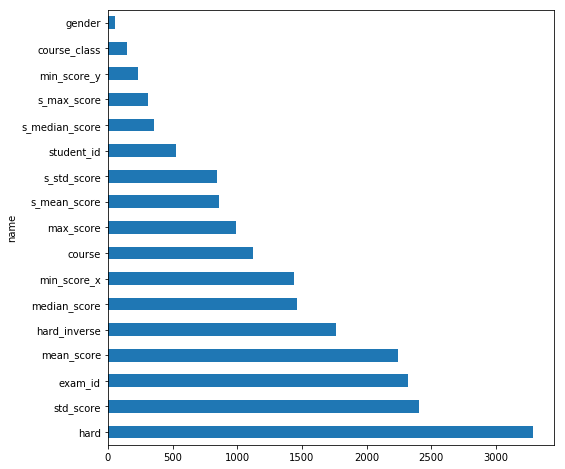

In [49]:
fi = []
for i in cv_model:
    tmp = {
        'name' : col,
        'score' : i.feature_importances_
    }
    fi.append(pd.DataFrame(tmp))
    
fi = pd.concat(fi)
fig = plt.figure(figsize=(8,8))
fi.groupby(['name'])['score'].agg('mean').sort_values(ascending=False).head(40).plot.barh()